Source [here](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset)

## Exploratory Data Analysis

In [119]:
import pandas as pd
import numpy as np
from summarytools import dfSummary
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, f1_score, confusion_matrix, accuracy_score

from category_encoders import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from warnings import filterwarnings
filterwarnings('ignore')

In [78]:
train = pd.read_csv("data/customer_churn_dataset-training-master.csv")

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [80]:
train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [81]:
train.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [82]:
train.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [83]:
train = train.dropna()

In [84]:
train[train.duplicated()]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


In [85]:
train.nunique()

CustomerID           440832
Age                      48
Gender                    2
Tenure                   60
Usage Frequency          30
Support Calls            11
Payment Delay            31
Subscription Type         3
Contract Length           3
Total Spend           68363
Last Interaction         30
Churn                     2
dtype: int64

In [86]:
dfSummary(train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CustomerID[float64],Mean (sd) : 225398.7 (129531.9)min < med < max:2.0 < 226125.5 < 449999.0IQR (CV) : 224117.5 (1.7),"440,832 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACfElEQVR4nO3YP6/SYBiG8ecFDpQ/lhCOsHVxNHFgZPEb+GFd3SSBL8Dg4sRCSAiUUA+hVFxkcBBoK+254/WbzwNP+l5py3Hn89mA165S9gLAPWplL4A/OeeaZlbP8REVM/tZwqyZ2fF8Pr/kmP+rm6HmvHAPW/yWf3Dghe/unGv2+/1Pvu/3sswnSfIURdG7TqfzvVKpxEXNXux2u41z7vMjrtvVUPNeuEcufk3evc3Mttvt3jn3xcwOGcaz3pn8TqczGI/Hu263m/p7F4tFbz6fvx2NRt+Gw+GmqFkzszAMvel02luv13UzKzZUM6v7vt8bj8cvaS9cGIbeZDIZrNfrZ+fcLuN+pRz4crl8M5vNPgZB8FytVlPN57kzxXHsJUnyvtFofB0MBj/SbW222WyaZmbtdvuQdj7P7EWSJL6Z+c65LONXn2B3vaN2u93Uy0dR9BTH8YcgCKppD9us/AP3PK81Go0ORd6Zfs+2TqdTNd3G5ct73reevg/7MXU8HmtZD9vsdRx40Xemy6yiPOd9z2vDw3/1Z32U/K8Hri7Hq8PVM+P/qJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBQu+ePwjD00n7wfr/3zMyiKPJWq1WryHnV71bdO+/8PX39Ai9SYfXEvrAfAAAAAElFTkSuQmCC"">",0(0.0%)
2,Age[float64],Mean (sd) : 39.4 (12.4)min < med < max:18.0 < 39.0 < 65.0IQR (CV) : 19.0 (3.2),48 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtklEQVR4nO3csW7aQBzH8f9BiBxAthAq2Vg6VurAyEP0YfsIHfIEGbpkYosUIRBuEMbQpUhEpWDuoPhnfz/7BUf6GnM+n912uzWg7Bq3PgCgiLtbH0AVOecezOzec/hqu92+X/J4qoBQL8w599Dv97/FcdzzGT+fz6fOue/E+hGhXt59HMe98Xj8niTJ8pyBs9ksenp66r29vd2bGaHuIdQrSZJkORgMfnkMfbj4wVQAkylI4Bv1HwImRPFms2ld+njqjlAPCJkQZVkW5Xn+Zblc/jAzn0s/DiDUw7wnRJPJpPf8/Nxer9fNax1cHRHqET4Toul0ymToCphMQQKhQkKpL/0sRWKntKHWdSkyz/OWmcXOOd8/UckTtLShWg2XItM0bWVZ9nU4HDabzeZZ//OO6gl6SplDNbN6LUWuVqu7KIrao9Fo+fj4OD13vOoJWsRVQw38jVnbFZ5Op+N7cpoJnqBFXC3U0N+YrPBg3zW/Ub1/Y5qxwoOPToYa+nBGkiRTn8sYKzzYdzRUHs5AWZz6RpV9OCPwfmRtJ3JlVeg3qtrDGaH3I7kalE/p76P6CL0feeurAf5WyVB3fO9HMpErH56eggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYRKP+ZXR4E7Gxpmtgn4+JDxR9/wQqgVErKzIc/zVpqmn7vd7kuj0cjO/ezQ8afe8EKoFRKys+HProZPo9HoZ8CuCK/xRd7wQqgV5LOzYberIXRXRMBbXo7uqmAyBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmF3pQym82ic//wYrGIzMzSNI1eX1/b/3O86merHnfo+CJ9/QanWJbjhD2qpQAAAABJRU5ErkJggg=="">",0(0.0%)
3,Gender[object],1. Male2. Female,"250,252 (56.8%)190,580 (43.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABNklEQVR4nO3bQWqDQByF8TdFQrMZEcHDeIgetoeY24g4iyZkM13URTzAvBH7/U7wRz6EBF8opQhwCJLukm6tD7mwVynl0fqIM+jGcfyKMQ6tD7mqnPMaQvgmOKmLMQ7zPD/6vn+2PuZqtm37TCkNy7LcJBGbJPV9/5ym6af1MRd1b33AWXy0PgD/B7HBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTad9PeRX+tDrojnetTlnNeU0iA+8qsi57xKerW+4wwYvNTH4GUXmPLBhTfbEW+hipjyvWF2VxdTvh2zu/qY8h3xi7wi/tSFDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTZM+XY8g/qY8r1hdlcXg5cjBi8V/QIKW2rfxJVRAgAAAABJRU5ErkJggg=="">",0(0.0%)
4,Tenure[float64],Mean (sd) : 31.3 (17.3)min < med < max:1.0 < 32.0 < 60.0IQR (CV) : 30.0 (1.8),60 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmElEQVR4nO3Yv2/aQBiH8fcgRMeP2iJQsrF0jNQBKUuWbh37x3bt1gGkzgxdOmVBkSICwg3CGLq0VZYk2GdMvtLzWZM3d+QeIzi33+8NeOtqp94AcIizU28A5XLONc3svOD4Zr/fP77FtQn1GYH/9JqZ7U4w6y8uLj7HcdwuMvzw8LByzn0zs3XVay+Xy7lz7utzsR411MDDNgt8wotyzjV7vd6XKIq6eWezLGskSfKh0+n8qtVqaVWzZmZpmnozu7q+vv7R7/eXeWZns9m7yWTyaTgc9uv1eu5QQ9ZeLBZ+PB537+/vz82s2lBDDvuf156yIzqPoqh7c3PzGMdxrkO7vb3tTqfT96PR6Ofl5e

In [87]:
gender_churn = train.groupby(['Churn', 'Gender']).size().reset_index(name='Count')
gender_churn['Proportion'] = gender_churn['Count']/gender_churn.groupby('Churn')['Count'].transform('sum')
gender_churn['Proportion'] = gender_churn['Proportion'].round(3)*100

gender_churn

,Churn,Gender,Count,Proportion
0,0.0,Female,63522,33.3
1,0.0,Male,127311,66.7
2,1.0,Female,127058,50.8
3,1.0,Male,122941,49.2


It seems like women are less likely to churn:

In [88]:
fig = px.bar(
    gender_churn, 
    x='Churn', 
    y='Proportion', 
    color='Gender', 
    title='Gender distribution by churn status',
    labels={'Proportion': 'Proportion (%)', 'Churn': 'Churn'},
    barmode='stack',
    text_auto=True)

fig.update_layout(
    width=600,
    height=400,
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['0', '1']))

fig.show()

In [89]:
subscription_type_churn = train.groupby(['Churn', 'Subscription Type']).size().reset_index(name='Count')
subscription_type_churn['Proportion'] = subscription_type_churn['Count']/subscription_type_churn.groupby('Churn')['Count'].transform('sum')
subscription_type_churn['Proportion'] = subscription_type_churn['Proportion'].round(3)*100

subscription_type_churn

,Churn,Subscription Type,Count,Proportion
0,0.0,Basic,59816,31.3
1,0.0,Premium,65505,34.3
2,0.0,Standard,65512,34.3
3,1.0,Basic,83210,33.3
4,1.0,Premium,83173,33.3
5,1.0,Standard,83616,33.4


And the Subscription Type doesn't give much information about churning or not

In [90]:
fig = px.bar(
    subscription_type_churn, 
    x='Churn', 
    y='Proportion', 
    color='Subscription Type', 
    title='Subscription Type distribution by churn status',
    labels={'Proportion': 'Proportion', 'Churn': 'Churn Category'},
    barmode='stack',
    text_auto=True)

fig.update_layout(
    width=600,
    height=400,
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['0', '1']))

fig.show()

In [91]:
contract_churn = train.groupby(['Churn', 'Contract Length']).size().reset_index(name='Count')
contract_churn['Proportion'] = contract_churn['Count']/contract_churn.groupby('Churn')['Count'].transform('sum')
contract_churn['Proportion'] = contract_churn['Proportion'].round(3)*100

contract_churn

,Churn,Contract Length,Count,Proportion
0,0.0,Annual,95552,50.1
1,0.0,Quarterly,95281,49.9
2,1.0,Annual,81646,32.7
3,1.0,Monthly,87104,34.8
4,1.0,Quarterly,81249,32.5


On the other hand, all customers with monthly contracts are marked as churned. But we need to be careful with this data, because if churn is measured monthly, it can make customers with monthly contracts always appear as churned. 

In [92]:
fig = px.bar(
    contract_churn, 
    x='Churn', 
    y='Proportion', 
    color='Contract Length', 
    title='Contract Length distribution by churn status',
    labels={'Proportion': 'Proportion', 'Churn': 'Churn Category'},
    barmode='stack',
    text_auto=True)

fig.update_layout(
    width=600,
    height=400,
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['0', '1']))

fig.show()

Looking at the numerical variables, those who __do not churn__ are:

* Less likely to make alot of support calls.

* Less likely to delay the payment for more than 20 days.

* Less likely to have a low total spending.

* Similar in Tenure, Usage Frequency and Last Interaction as those who __churn__.

* Relatively younger than those who __churn__.

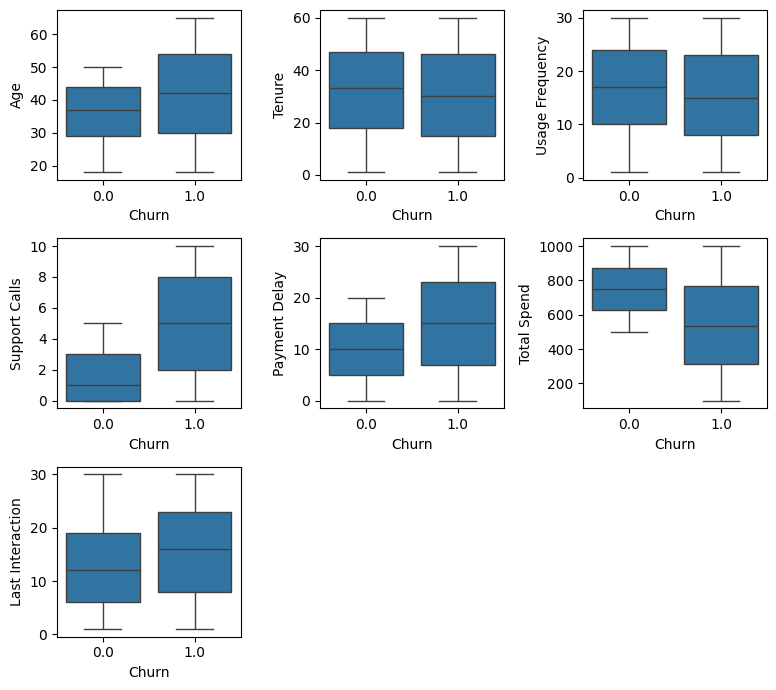

In [93]:
fig, axes = plt.subplots(3,3,figsize=(8,7))

sns.boxplot(data=train, x='Churn', y='Age', ax=axes[0,0])
sns.boxplot(data=train, x='Churn', y='Tenure', ax=axes[0,1])
sns.boxplot(data=train, x='Churn', y='Usage Frequency', ax=axes[0,2])
sns.boxplot(data=train, x='Churn', y='Support Calls', ax=axes[1,0])
sns.boxplot(data=train, x='Churn', y='Payment Delay', ax=axes[1,1])
sns.boxplot(data=train, x='Churn', y='Total Spend', ax=axes[1,2])
sns.boxplot(data=train, x='Churn', y='Last Interaction', ax=axes[2,0])

axes[2, 1].remove()
axes[2, 2].remove()

plt.tight_layout()

Now, taking a look at the correlation between the numerical variables, it is possible to see that:

* Higher values of Support Calls are associated with higher Age and Payment Delay.

* Higher values of Total Spend are associated with lower values of Support Calls and Payment Delay.

<Axes: >

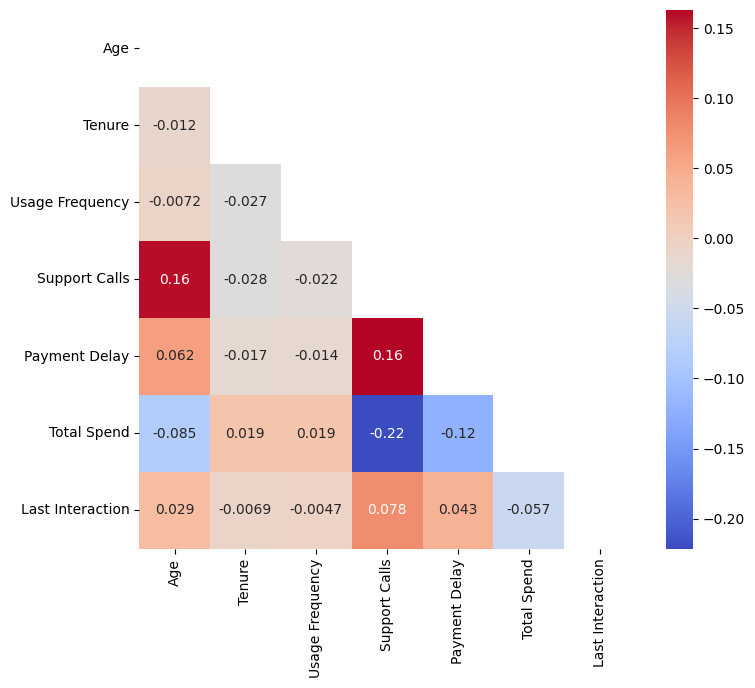

In [94]:
numeric_cols = cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

corr_matrix = train[numeric_cols].corr()

mask = np.triu(corr_matrix)

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')

In [95]:
# train.drop(columns='CustomerID', inplace=True)

# 1:09

# Modeling

The proportion of churn and non-churn observations are similar, with 56% of churn and 43% of non-churn: 

In [96]:
train['Churn'].value_counts(1)

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

If the proportions were something like 80% and 20%, we could apply a technique known as __class weighting__, which is used in classification problems with unbalanced classes. This technique assigns higher weights to observations of the minoritary class, forcing the algorithm to pay closer attention to these observations and making it less likely to make mistakes.

Because in this particular dataset the classes aren't so unbalanced, there's no need to do such thing, so we'll just skip this step.

In [97]:
train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [98]:
X_train = train.drop(columns = ['Churn', 'CustomerID'])
y_train = train['Churn']

The proportion of churn and non-churn on the test dataset is similar:

In [99]:
test = pd.read_csv("data/customer_churn_dataset-testing-master.csv")
test['Churn'].value_counts(1)

X_test = test.drop(columns = ['Churn', 'CustomerID'])
y_test = test['Churn']

# X = pd.concat([X_train, X_test], axis=0)
# y = pd.concat([y_train, y_test], axis=0)

In [108]:
XGBoost_model = XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=1e-3, random_state=123, eval_metric='error')
LightGBM_model = LGBMClassifier(n_estimators=1000, max_depth=8, num_leaves=2^8, learning_rate=10e-3, random_state=123, verbose=-1)
CatBoost_model = CatBoostClassifier(n_estimators=1000, max_depth=8, learning_rate=1e-3, random_state=123, verbose=0)
LogisticRegression_model = LogisticRegression(random_state=123, max_iter=1000)

### Cross Validation

I will use stratified cross-validation to ensure that each fold maintains the same proportion of churn and non-churn instances as the entire dataset.

In [120]:
k = 5
threshold = 0.5
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
precision_recall_auc_list = []
roc_auc_list = []

# The 'split' method will be applied to the 'folds' object, and for each fold,
# it will return the indices of the training instances and the test instances for that fold
for k, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    print(f"------------ Fold: {k + 1} ------------")

    # training and validation sets for this fold
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[val_index]
    y_test_fold = y_train.iloc[val_index]

    encoder = CatBoostEncoder()

    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')

    cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
    num_pipeline = Pipeline([('imputer', num_imputer)])

    cat_columns = X_train_fold.select_dtypes(include = ['object']).columns
    num_columns = X_train_fold.select_dtypes(exclude = ['object']).columns

    X_train_fold[cat_columns] = cat_pipeline.fit_transform(X_train_fold[cat_columns], y_train_fold)
    X_train_fold[num_columns] = num_pipeline.fit_transform(X_train_fold[num_columns])

    X_test_fold[cat_columns] = cat_pipeline.transform(X_test_fold[cat_columns])
    X_test_fold[num_columns] = num_pipeline.transform(X_test_fold[num_columns])

    XGBoost_model.fit(X_train_fold, y_train_fold)

    y_pred_proba = XGBoost_model.predict_proba(X_test_fold)[:,1]

    y_pred = np.where(y_pred_proba > threshold, 1, 0)

    precision, recall, thresholds = precision_recall_curve(y_test_fold, y_pred)

    precision_recall_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test_fold, y_pred_proba)
    accuracy_scores = accuracy_score(y_test_fold, y_pred)
    precision_scores = precision_score(y_test_fold, y_pred)
    recall_scores = recall_score(y_test_fold, y_pred)
    f1scores = f1_score(y_test_fold, y_pred)

    precision_list.append(precision_scores)
    recall_list.append(recall_scores)
    accuracy_list.append(accuracy_scores)
    f1_score_list.append(f1scores)
    precision_recall_auc_list.append(precision_recall_auc)
    roc_auc_list.append(roc_auc)

    print(f"Precision: {precision_scores:.3f}")
    print(f"Recall: {recall_scores:.3f}")
    print(f"Accuracy: {accuracy_scores:.3f}")
    print(f"F1 Score: {f1scores:.3f}")
    print(f"Precision-recall AUC: {precision_recall_auc:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")


    


------------ Fold: 1 ------------
Precision: 1.000
Recall: 0.946
Accuracy: 0.969
F1 Score: 0.972
Precision-recall AUC: 0.988
ROC AUC: 0.973
------------ Fold: 2 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.968
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972
------------ Fold: 3 ------------
Precision: 1.000
Recall: 0.894
Accuracy: 0.940
F1 Score: 0.944
Precision-recall AUC: 0.977
ROC AUC: 0.971
------------ Fold: 4 ------------
Precision: 1.000
Recall: 0.897
Accuracy: 0.941
F1 Score: 0.946
Precision-recall AUC: 0.978
ROC AUC: 0.972
------------ Fold: 5 ------------
Precision: 1.000
Recall: 0.944
Accuracy: 0.969
F1 Score: 0.971
Precision-recall AUC: 0.988
ROC AUC: 0.972
